In [1]:
import sys
import sklearn
import numpy as np

print("Python version:", sys.version)
print("Sklearn version:", sklearn.__version__)
print("NumPy version:", np.__version__)


Python version: 3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]
Sklearn version: 1.7.2
NumPy version: 2.2.6


In [3]:
from pyspark.sql import SparkSession

# 🔁 Restart Spark JVM
spark = (
    SparkSession.builder
        .appName("ML Project SKLearn Prep")
        .config("spark.driver.memory", "12g")
        .config("spark.sql.execution.pyspark.udf.faulthandler.enabled", "true")
        .getOrCreate()
)

print("✅ Spark Session Ready. Version:", spark.version)


✅ Spark Session Ready. Version: 4.0.0


In [4]:
import os
from pyspark.sql import SparkSession

# My Spark session
spark

# Path to my folder with CSV files
folder = r"C:\Users\Ranveer Verma\Desktop\ML Project"

# Getting all CSV filenames
csv_files = [f for f in os.listdir(folder) if f.endswith(".csv")]
print(f"Found {len(csv_files)} CSV files.")

# Loading each CSV into a DataFrame
dfs = []
for file in csv_files:
    path = os.path.join(folder, file)
    df = spark.read.option("header", True).option("inferSchema", True).csv(path)
    dfs.append(df)
    print(f"✅ Loaded {file} with {df.count()} rows")

Found 8 CSV files.
✅ Loaded Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv with 225745 rows
✅ Loaded Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv with 286467 rows
✅ Loaded Friday-WorkingHours-Morning.pcap_ISCX.csv with 191033 rows
✅ Loaded Monday-WorkingHours.pcap_ISCX.csv with 529918 rows
✅ Loaded Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv with 288602 rows
✅ Loaded Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv with 170366 rows
✅ Loaded Tuesday-WorkingHours.pcap_ISCX.csv with 445909 rows
✅ Loaded Wednesday-workingHours.pcap_ISCX.csv with 692703 rows


In [5]:
# Combining all DataFrames
if dfs:
    combined_df = dfs[0]
    for df in dfs[1:]:
        combined_df = combined_df.unionByName(df, allowMissingColumns=True)
    print("✅ Combined all CSV files into a single DataFrame")
    print(f"Total rows: {combined_df.count()}")
else:
    print("⚠️ No CSV files found")

✅ Combined all CSV files into a single DataFrame
Total rows: 2830743


In [6]:
from pyspark.sql.functions import col, trim

# 1️⃣ Remove leading/trailing spaces from all column names
combined_df = combined_df.toDF(*[c.strip() for c in combined_df.columns])

# 2️⃣ Trim whitespace from the Label column (important for CIC-IDS)
df_filled = combined_df.withColumn("Label", trim(col("Label")))

print("✅ df_filled created successfully")
df_filled.printSchema()
df_filled.show(5)

✅ df_filled created successfully
root
 |-- Destination Port: integer (nullable = true)
 |-- Flow Duration: integer (nullable = true)
 |-- Total Fwd Packets: integer (nullable = true)
 |-- Total Backward Packets: integer (nullable = true)
 |-- Total Length of Fwd Packets: integer (nullable = true)
 |-- Total Length of Bwd Packets: integer (nullable = true)
 |-- Fwd Packet Length Max: integer (nullable = true)
 |-- Fwd Packet Length Min: integer (nullable = true)
 |-- Fwd Packet Length Mean: double (nullable = true)
 |-- Fwd Packet Length Std: double (nullable = true)
 |-- Bwd Packet Length Max: integer (nullable = true)
 |-- Bwd Packet Length Min: integer (nullable = true)
 |-- Bwd Packet Length Mean: double (nullable = true)
 |-- Bwd Packet Length Std: double (nullable = true)
 |-- Flow Bytes/s: double (nullable = true)
 |-- Flow Packets/s: double (nullable = true)
 |-- Flow IAT Mean: double (nullable = true)
 |-- Flow IAT Std: double (nullable = true)
 |-- Flow IAT Max: integer (nulla

In [7]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

distinct_labels = df_filled.select("Label").distinct()
window = Window.orderBy("Label")
label_mapping = distinct_labels.withColumn("label_index", row_number().over(window) - 1)

In [8]:
df_indexed = df_filled.join(label_mapping, on="Label", how="left")
df_indexed.select("Label", "label_index").show(5)


+------+-----------+
| Label|label_index|
+------+-----------+
|BENIGN|          0|
|BENIGN|          0|
|BENIGN|          0|
|BENIGN|          0|
|BENIGN|          0|
+------+-----------+
only showing top 5 rows


In [9]:
df_indexed.select("Label", "label_index").distinct().orderBy("label_index").show(50, truncate=False)

+--------------------------+-----------+
|Label                     |label_index|
+--------------------------+-----------+
|BENIGN                    |0          |
|Bot                       |1          |
|DDoS                      |2          |
|DoS GoldenEye             |3          |
|DoS Hulk                  |4          |
|DoS Slowhttptest          |5          |
|DoS slowloris             |6          |
|FTP-Patator               |7          |
|Heartbleed                |8          |
|Infiltration              |9          |
|PortScan                  |10         |
|SSH-Patator               |11         |
|Web Attack � Brute Force  |12         |
|Web Attack � Sql Injection|13         |
|Web Attack � XSS          |14         |
+--------------------------+-----------+



In [10]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

distinct_labels = df_filled.select("Label").distinct()
window = Window.orderBy("Label")
label_mapping = distinct_labels.withColumn("label_index", row_number().over(window) - 1)

In [11]:
# Get all numeric columns (excluding the label)
numeric_cols = [col_name for col_name, dtype in df_indexed.dtypes if dtype in ('int', 'double', 'float')]

# Showing first few numeric columns for verification
print(numeric_cols[:10])


['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std']


In [12]:
from pyspark.sql.types import IntegerType, DoubleType, FloatType, LongType
from pyspark.sql.functions import col, isnan, when, count, expr
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import functions as F

# -----------------------------
# 1. Select numeric columns
# -----------------------------
numeric_cols = [
    f.name for f in df_indexed.schema.fields
    if isinstance(f.dataType, (IntegerType, DoubleType, FloatType, LongType))
]

# -----------------------------
# 2. Fill NaNs with 0
# -----------------------------
df_indexed = df_indexed.fillna(0, subset=numeric_cols)

# -----------------------------
# 3. Remove constant columns
# -----------------------------
non_constant_cols = []
for c in numeric_cols:
    stats = df_indexed.agg(F.max(c).alias("max_val"), F.min(c).alias("min_val")).collect()[0]
    if stats["max_val"] != stats["min_val"]:
        non_constant_cols.append(c)
numeric_cols = non_constant_cols
print("Numeric columns after removing constants:", numeric_cols[:10])

# -----------------------------
# 4. Remove zero-variance columns
# -----------------------------
stddev_cols = [
    (c, df_indexed.agg(F.stddev(c).alias("std")).collect()[0]["std"])
    for c in numeric_cols
]
non_zero_std_cols = [c for c, std in stddev_cols if std and std > 0]
print("Numeric columns after removing zero-variance:", non_zero_std_cols[:10])

# Exclude label column
feature_cols = [c for c in non_zero_std_cols if c != "label_index"]

# -----------------------------
# 5. Assemble features
# -----------------------------
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features_vector"
)
df_vector = assembler.transform(df_indexed)

# -----------------------------
# 6. Standardize features
# -----------------------------
scaler = StandardScaler(
    inputCol="features_vector",
    outputCol="scaled_features",
    withMean=False,
    withStd=True
)
scaler_model = scaler.fit(df_vector)
df_scaled = scaler_model.transform(df_vector)

# -----------------------------
# 7. Quick look at final DataFrame that we get
# -----------------------------
df_scaled.select("scaled_features", "label_index").show(5, truncate=False)

print("✅ Preprocessing complete. Data ready for ML!")

Numeric columns after removing constants: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std']
Numeric columns after removing zero-variance: ['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std']
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [13]:
# -----------------------------
# Sample 700k rows from the dataset
# -----------------------------
sample_df = df_scaled.sample(withReplacement=False, fraction=0.25, seed=42)  
print(f"Sampled dataset count: {sample_df.count()}")

Sampled dataset count: 708271


In [14]:
import numpy as np

# ✅ Safe conversion (keeping rows aligned)
rdd = (
    sample_df
    .select("scaled_features", "label_index")
    .rdd
    .map(lambda row: (row["scaled_features"].toArray(), int(row["label_index"])))
)

# Collect once and unzip
data = rdd.collect()
X_full_np = np.array([row[0] for row in data])
y_full_np = np.array([row[1] for row in data])

print("✅ Conversion Complete")
print("X_full_np shape:", X_full_np.shape)
print("y_full_np shape:", y_full_np.shape)




✅ Conversion Complete
X_full_np shape: (709031, 68)
y_full_np shape: (709031,)


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# ------------------------------------------
# 1. Train / Test Split (Stratified)
# ------------------------------------------
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X_full_np, y_full_np,
    test_size=0.2,
    stratify=y_full_np,
    random_state=42,
)

print("X_train:", X_train_np.shape, "   X_test:", X_test_np.shape)
print("y_train:", y_train_np.shape, "   y_test:", y_test_np.shape)

# ------------------------------------------
# 2. Compute Balanced Class Weights
# ------------------------------------------
num_classes = int(y_full_np.max() + 1)
classes = np.arange(num_classes)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_np
)

class_weight_dict = {int(c): float(w) for c, w in zip(classes, class_weights)}
print("\n✅ Class Weights (first few):", list(class_weight_dict.items())[:5])


X_train: (567224, 68)    X_test: (141807, 68)
y_train: (567224,)    y_test: (141807,)

✅ Class Weights (first few): [(0, 0.08301578067315749), (1, 96.96136752136752), (2, 1.4753017062005827), (3, 18.232851173256186), (4, 0.8181685742515704)]


IMPLEMENTING XGBOOST ON THE SAMPLE DATASET

In [32]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

# Convert class weights → sample weights
sample_w_train_xgb = np.vectorize(class_weight_dict.get)(y_train_np)

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train_np, label=y_train_np, weight=sample_w_train_xgb)
dtest = xgb.DMatrix(X_test_np, label=y_test_np)

# XGBoost parameters
xgb_params = {
    "objective": "multi:softprob",
    "num_class": int(max(y_train_np) + 1),
    "eval_metric": "mlogloss",
    "learning_rate": 0.15,
    "max_depth": 7,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 2.0,
    "tree_method": "hist",
    "nthread": 6
}

print("🚀 Training XGBoost...")
xgb_model = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=300,
    evals=[(dtest, "test")],
    early_stopping_rounds=30,
    verbose_eval=25
)

print("\n✅ Training Complete!")

# Predictions
y_prob = xgb_model.predict(dtest)
y_pred = np.argmax(y_prob, axis=1)

acc = accuracy_score(y_test_np, y_pred)
f1_macro = f1_score(y_test_np, y_pred, average="macro")
f1_weighted = f1_score(y_test_np, y_pred, average="weighted")

print("\n===== XGBoost Results =====")
print(f"Accuracy:       {acc:.4f}")
print(f"F1 (Macro):     {f1_macro:.4f}")
print(f"F1 (Weighted):  {f1_weighted:.4f}")
print("\nClassification Report:\n", classification_report(y_test_np, y_pred))



🚀 Training XGBoost...
[0]	test-mlogloss:1.76451
[25]	test-mlogloss:0.06032
[50]	test-mlogloss:0.01197
[75]	test-mlogloss:0.00820
[100]	test-mlogloss:0.00750
[125]	test-mlogloss:0.00732
[150]	test-mlogloss:0.00722
[175]	test-mlogloss:0.00718
[200]	test-mlogloss:0.00714
[225]	test-mlogloss:0.00710
[250]	test-mlogloss:0.00704
[275]	test-mlogloss:0.00700
[299]	test-mlogloss:0.00697

✅ Training Complete!

===== XGBoost Results =====
Accuracy:       0.9986
F1 (Macro):     0.8690
F1 (Weighted):  0.9986

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    113880
           1       0.65      0.99      0.78        97
           2       1.00      1.00      1.00      6408
           3       0.98      1.00      0.99       518
           4       1.00      1.00      1.00     11555
           5       1.00      0.98      0.99       274
           6       0.99      1.00      1.00       290
           7       1.00      1.00      1.

c:\anaconda\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\anaconda\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\anaconda\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


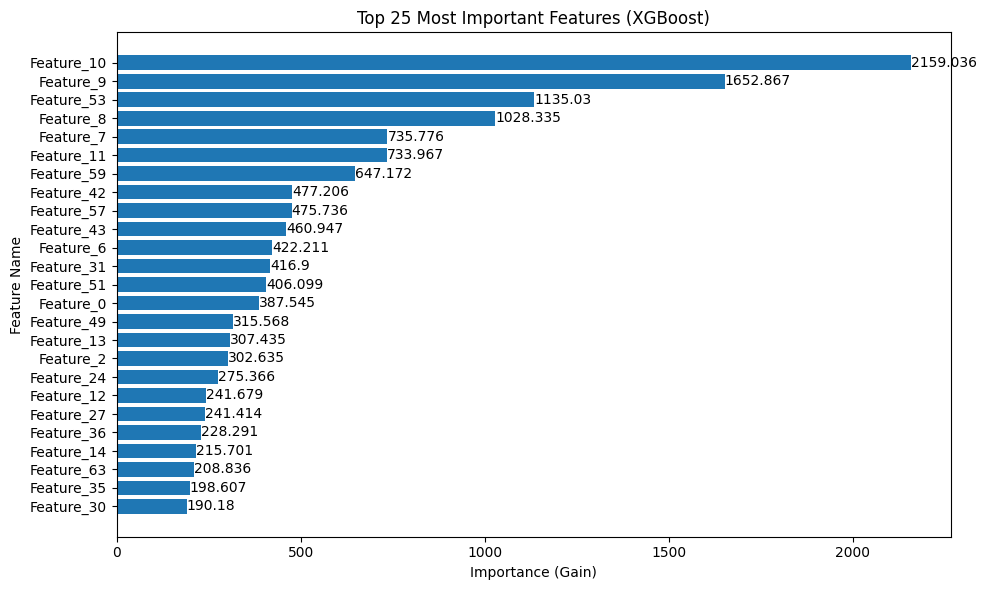

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# ✅ xgb_model is already a Booster — no .get_booster() needed
booster = xgb_model  

# Extract importance scores
importance_dict = booster.get_score(importance_type='gain')

# Sort top 25
sorted_items = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:25]

# ✅ Map fN → real feature names
mapped_features = []
for f, score in sorted_items:
    idx = int(f[1:])   # convert 'f10' -> 10
    mapped_features.append((feature_names[idx], round(score, 3)))

feat_labels = [item[0] for item in mapped_features]
feat_scores = [item[1] for item in mapped_features]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_labels, feat_scores)
plt.xlabel("Importance (Gain)")
plt.ylabel("Feature Name")
plt.title("Top 25 Most Important Features (XGBoost)")

# Add value labels
for i, v in enumerate(feat_scores):
    plt.text(v + 0.01, i, str(v), va='center')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
